# Fitting Data with Copulas

In [6]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import matplotlib.pyplot as plt
from IPython import display
import seaborn as sns
sns.set_theme(style="whitegrid")

import numpy as np
import math
from scipy.stats import norm, \
    beta, cauchy, expon, rayleigh, uniform, multivariate_t, t, \
    rankdata, kendalltau, pearsonr
from scipy.stats.mstats import spearmanr
import scipy.integrate as integrate
import pandas as pd
from scipy.optimize import brentq, fsolve

### Données originales

| x    | y    |
|------|------|
| 0.6  | 0.8  |
| 0.2  | 0.4  |
| 1.2  | 0.5  |
| 0.1  | 0.2  |


### Rangs des observations

| x | y |
| - | - |
| 3 | 4 |
| 2 | 2 |
| 4 | 3 |
| 1 | 1 |

Ici, chaque valeur a été remplacée par son **rang dans l’ordre croissant** pour x et y séparément.  
On fait cela pour travailler uniquement sur **l’ordre relatif** des données, ce qui rend l’analyse moins sensible aux valeurs extrêmes et mieux adaptée à l’estimation d’une copule.


In [3]:
def pobs(X):
    # X.shape = (n,d), n = nombre d'observations, d = dimension des données
    n, d = X.shape
    # Calcule le rang de chaque valeur dans chaque colonne (dimension) séparément
    U = rankdata(X, method='ordinal', axis=0) / float(n+1)
    # On divise par (n+1) pour ramener les rangs dans (0,1) et éviter d'avoir exactement 0 ou 1
    return U


Ce code simule des données corrélées à partir d’une copule gaussienne.
D’abord, il génère des variables normales multivariées avec une corrélation donnée, puis applique la fonction de répartition normale pour obtenir des variables uniformes sur \[0,1] tout en conservant la dépendance.
Ensuite, il transforme ces uniformes en nouvelles variables suivant des lois marginales choisies (Normale, Beta, Cauchy) via la fonction quantile correspondante.
Le but est de montrer comment on peut construire une loi jointe avec marges arbitraires tout en contrôlant la dépendance grâce à la copule.


In [ ]:
# Paramètres de corrélation et dimension
r = 0.8
P = np.asarray([
    [1, r],
    [r, 1]
])
d = P.shape[0]
n = 500

# 1) Génération d'un échantillon gaussien corrélé via Cholesky
A = np.linalg.cholesky(P)                   # Cholesky(P) : introduit la corrélation
Z = np.random.normal(size=(n, d))           # Z ~ N(0, I_d), i.i.d.
U_Gauss = norm.cdf(np.matmul(Z, A))         # PIT gaussien : passage en U ~ Uniforme[0,1] corrélées (copule gaussienne)

# 2) Construction de deux jeux de marges différentes en conservant la dépendance
H1 = np.empty_like(U_Gauss)                 # H1 : marges normales
H1[:, 0] = norm.ppf(U_Gauss[:, 0])         # marge 1 ~ N(0,1)
H1[:, 1] = norm.ppf(U_Gauss[:, 1])         # marge 2 ~ N(0,1)

H2 = np.empty_like(U_Gauss)                 # H2 : marges mixtes
H2[:, 0] = beta.ppf(U_Gauss[:, 0], 2, 5)   # marge 1 ~ Beta(2,5)
H2[:, 1] = cauchy.ppf(U_Gauss[:, 1])       # marge 2 ~ Cauchy

# 3) Pseudo-observations (rangs/(n+1)) pour l'estimation de copule
U1 = pobs(H1)                               # pseudo-U issus de H1 (marges normales)
U2 = pobs(H2)                               # pseudo-U issus de H2 (marges Beta/Cauchy)



On trace deux jeux de données brutes (H1, H2) avec leurs mesures de dépendance (rho de Pearson, tau de Kendall), puis leurs versions en pseudo-observations (U1, U2) uniformes sur [0,1].  
L’idée : comparer la dépendance avant/après suppression des marges. La forme marginale change (H1 vs H2), mais la structure de dépendance reste visible dans l’espace (U, V), ce qui prépare l’estimation de la copule.


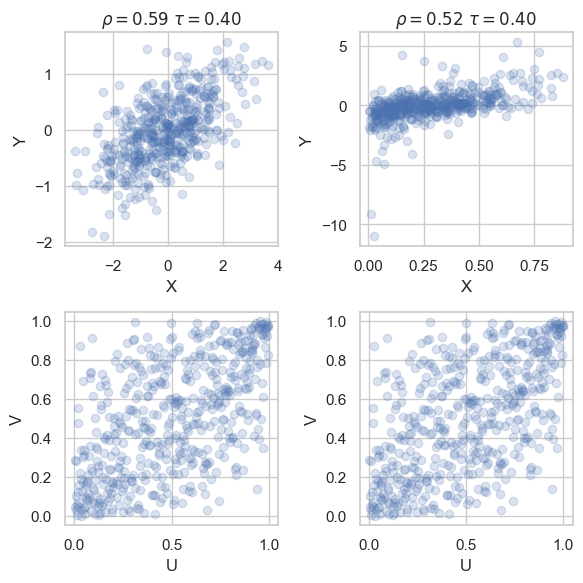

In [8]:
# --- Visualisation de la dépendance avant et après transformation en pseudo-observations ---
plt.figure(figsize=(6, 6))

# (1) H1 : marges normales
plt.subplot(2, 2, 1)
plt.scatter(H1[:, 0], H1[:, 1], alpha=0.2)
t = kendalltau(H1[:, 0], H1[:, 1])
rho = pearsonr(H1[:, 0], H1[:, 1])[0]
plt.title(r'$\rho=%0.02f \ \tau=%0.02f$' % (rho, t.correlation))
plt.xlabel('X')
plt.ylabel('Y')

# (2) H2 : marges Beta / Cauchy
plt.subplot(2, 2, 2)
plt.scatter(H2[:, 0], H2[:, 1], alpha=0.2)
t = kendalltau(H2[:, 0], H2[:, 1])
rho = pearsonr(H2[:, 0], H2[:, 1])[0]
plt.title(r'$\rho=%0.02f \ \tau=%0.02f$' % (rho, t.correlation))
plt.xlabel('X')
plt.ylabel('Y')

# (3) U1 : pseudo-observations issues de H1
plt.subplot(2, 2, 3)
plt.scatter(U1[:, 0], U1[:, 1], alpha=0.2)
plt.xlabel('U')
plt.ylabel('V')

# (4) U2 : pseudo-observations issues de H2
plt.subplot(2, 2, 4)
plt.scatter(U2[:, 0], U2[:, 1], alpha=0.2)
plt.xlabel('U')
plt.ylabel('V')

plt.tight_layout()



On simule une **copule de Clayton** (paramètre `alpha = 6`) pour obtenir des paires uniformes corrélées, caractérisées par une **dépendance de queue inférieure**. On impose ensuite des **marges** spécifiques (Beta pour X, Cauchy pour Y) via les fonctions quantiles, puis on transforme les données en **pseudo-observations** (rangs normalisés) pour ne conserver que la **structure de dépendance** avant l’estimation de la copule.


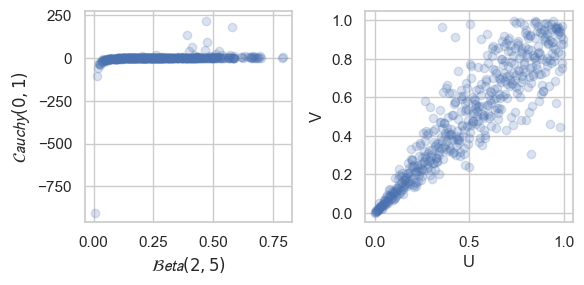

In [9]:
# --- Échantillonnage d'une copule de Clayton et changement de marges ---

alpha = 6  # paramètre de dépendance (queue inférieure marquée pour Clayton)
u = np.random.rand(n)  # U1 ~ Uniforme(0,1)
t = np.random.rand(n)  # variable auxiliaire pour l'échantillonnage conditionnel

# Formule d'échantillonnage conditionnel pour la copule de Clayton (dimension 2)
v = ((t / u**(-alpha - 1))**(-alpha / (1 + alpha)) - u**(-alpha) + 1)**(-1 / alpha)

# Paires (U1, U2) ~ copule de Clayton(alpha)
U_clayton = np.vstack([u, v]).T

# Imposer des marges : Beta(2,5) pour X, Cauchy(0,1) pour Y
H2 = np.empty_like(U_clayton)
H2[:, 0] = beta.ppf(U_clayton[:, 0], 2, 5)
H2[:, 1] = cauchy.ppf(U_clayton[:, 1])

# Visualisation : données brutes (H2) et pseudo-observations (U) issues des rangs
plt.figure(figsize=(6, 3))

plt.subplot(1, 2, 1)
plt.scatter(H2[:, 0], H2[:, 1], alpha=0.2)
plt.xlabel('$\\mathcal{Beta}(2,5)$')
plt.ylabel('$\\mathcal{Cauchy}(0,1)$')

U = pobs(H2)  # rangs/(n+1) par colonne : on efface l'effet des marges, on garde la dépendance
plt.subplot(1, 2, 2)
plt.scatter(U[:, 0], U[:, 1], alpha=0.2)
plt.xlabel('U')
plt.ylabel('V')

plt.tight_layout()


Les méthodes suivantes permmettent de calculer les paramètres des copules à partir des mesures d'association pour pouvoir simuler ces coupules de manière complète.

### Tau de Kendall

$$
\tau = 4 \int_0^1 \int_0^1 C(x,y) \, dC(x,y) \, dx \, dy
$$

$$
\tau = \frac{2}{n(n-1)} \sum_{i<j} \text{sgn}(x_i - x_j) \, \text{sgn}(y_i - y_j)
$$


### Copule Gaussienne

$$
\rho = \sin\left(\tau \frac{\pi}{2}\right)
$$


In [11]:
def ktau2gaussian(val, dependency='kendall'):
    if(dependency=='kendall'):
        r = np.sin(val * math.pi/2.0)
    elif(dependency=='spearman'):
        r = 2*np.sin(val * math.pi/6.0)
    return r


### Copule de Clayton  
$$ \alpha = \frac{2\tau}{1-\tau} $$


In [16]:
def ktau2clayton(val, dependency='kendall'):
    if(dependency=='kendall'):
        if(val<0 or val>=1):
            raise ValueError('Valid values of Kendall\'s Tau for the Clayton Copula are [0,1)')
        d = 2.0*val/(1.0-val)
    elif(dependency=='spearman'):
        raise NotImplementedError('Spearmans Rho currently unsupported for Clayton Copula family!')
    
    return d


### Copule de Gumbel  
$$ \alpha = \frac{1}{1-\tau} $$


In [12]:
def tau2gumbel(valeur, dependance='kendall'):
    if dependance == 'kendall':
        if valeur < 0 or valeur >= 1:
            raise ValueError("Valeurs valides du Tau de Kendall pour la copule de Gumbel : [0,1)")
        d = 1.0 / (1.0 - valeur)
    elif dependance == 'spearman':
        raise NotImplementedError("Rho de Spearman non pris en charge pour la copule de Gumbel")
    return d


### Copule de Frank  
$$ 4 \frac{\mathcal{D}_1(\alpha) - 1 }{\alpha} + 1 - \tau = 0 $$  
$$ \mathcal{D}_n(x) = \frac{n}{x^n} \int_0^x \frac{t^n}{e^t-1} \, dt $$  

où $\mathcal{D}_n(x)$ désigne la **fonction de Debye d’ordre $n$**.


In [13]:
import numpy as np
from scipy import integrate
from scipy.optimize import fsolve

def debye(x, n):
   
    n = float(n)
    sol = integrate.quad(lambda t: t**n / (np.exp(t) - 1.0), 0.0, x)
    return n * sol[0] / (x**n)

def _frank_kendall_fopt(alpha, tau):
    return 4 * (debye(alpha, 1) - 1) / alpha + 1 - tau

def ktau2frank(val, dependency='kendall'):
    if dependency == 'kendall':
        return fsolve(_frank_kendall_fopt, 1, args=(val))[0]
    elif dependency == 'spearman':
        raise NotImplementedError(
            "Spearman's Rho actuellement non supporté pour la copule de Frank."
        )
    else:
        raise ValueError("Type de dépendance inconnu. Utiliser 'kendall' ou 'spearman'.")


In [14]:
## Exemple Gaussien
r = 0.5  # Corrélation cible
P = np.asarray([
    [1, r],
    [r, 1]
])
d = P.shape[0]      # Dimension
n = 1000            # Taille de l’échantillon

# Décomposition de Cholesky
A = np.linalg.cholesky(P)

# Génération de vecteurs gaussiens
Z = np.random.normal(size=(n, d))

# Transformation en variables uniformes via la CDF normale
U_Gauss = norm.cdf(np.matmul(Z, A))

# Transformation en marges normales
H1 = np.empty_like(U_Gauss)
H1[:, 0] = norm.ppf(U_Gauss[:, 0])
H1[:, 1] = norm.ppf(U_Gauss[:, 1])

# Transformation en marges Beta et Cauchy
H2 = np.empty_like(U_Gauss)
H2[:, 0] = beta.ppf(U_Gauss[:, 0], 2, 5)
H2[:, 1] = cauchy.ppf(U_Gauss[:, 1])

# Calcul de tau de Kendall et transformation en paramètre de copule gaussienne
t1 = kendalltau(H1[:, 0], H1[:, 1])
c1_param = ktau2gaussian(t1.correlation)

t2 = kendalltau(H2[:, 0], H2[:, 1])
c2_param = ktau2gaussian(t2.correlation)

# Affichage : corrélation initiale, paramètres de copule et corrélations de Pearson
print(r, c1_param, c2_param,
      pearsonr(H1[:, 0], H1[:, 1])[0],
      pearsonr(H2[:, 0], H2[:, 1])[0])


0.5 0.41612638358428794 0.41612638358428794 0.41222293182050157 0.27258593480877513


En résumé, la simulation montre que :

* Pour les **données normales** (H1), la corrélation de Kendall et la corrélation de Pearson sont proches de la valeur initiale (≈ 0,45), ce qui confirme que la dépendance est bien conservée.
* Pour les **données transformées** (H2, lois Beta et Cauchy), la corrélation de Kendall reste identique (≈ 0,45) mais la corrélation de Pearson chute fortement (≈ 0,10), montrant que la structure de dépendance est préservée en termes d’**ordre** (copule) mais pas en termes de **relation linéaire**.


In [17]:
## Exemple avec copule Clayton

alpha = 6  # paramètre de dépendance
u = np.random.rand(n)   # variable uniforme U
t = np.random.rand(n)   # variable uniforme T

# Génération d'une deuxième variable liée à u par la copule de Clayton
v = ((t / u**(-alpha-1))**(-alpha/(1+alpha)) - u**(-alpha) + 1)**(-1/alpha)

# Matrice des données (U, V)
U_clayton = np.vstack([u, v]).T

# H1 : Transformation vers loi Normale (lois marginales normales)
H1 = np.empty_like(U_clayton)
H1[:, 0] = norm.ppf(U_clayton[:, 0])
H1[:, 1] = norm.ppf(U_clayton[:, 1])

# H2 : Transformation vers lois Beta et Cauchy (marges non gaussiennes)
H2 = np.empty_like(U_clayton)
H2[:, 0] = beta.ppf(U_clayton[:, 0], 2, 5)
H2[:, 1] = cauchy.ppf(U_clayton[:, 1])

# Calcul de tau de Kendall et conversion en paramètre de Clayton
t1 = kendalltau(H1[:, 0], H1[:, 1])
c1_param = ktau2clayton(t1.correlation)

t2 = kendalltau(H2[:, 0], H2[:, 1])
c2_param = ktau2clayton(t2.correlation)

print(alpha, c1_param, c2_param)



6 5.649076597960246 5.649076597960246


En résumé, la simulation montre que :  

* Pour les **données normales** (H1), le paramètre de Clayton estimé (~5,64) est très proche de la valeur initiale (6), ce qui indique que la structure de dépendance modélisée par la copule est fidèlement conservée.  
* Pour les **données transformées** (H2, lois Beta et Cauchy), le paramètre estimé reste identique (~5,64), montrant que les transformations marginales n’affectent pas la dépendance capturée par la copule Clayton.  
* Cela illustre que la copule isole la dépendance des distributions marginales : même si les lois changent, la force et la forme de la dépendance restent identiques.  
